**Version 1.0**

Loading dataset from: /Users/nurulmansibtalukder/Desktop/WAY TO EVERYTHING/BUET_STUFFS/3-2/CSE 330 - Machine Learning Sessional/ML-Project-CSE330---F1-Pitstop-Strategy-Predictor/DATA_SET_BUILDER/f1_complete_dataset_2020_2024.csv
✓ Loaded dataset: 114626 rows, 39 columns
Columns: ['season', 'round_number', 'race_name', 'driver', 'team', 'grid_position', 'qualifying_position', 'lap_number', 'lap_time', 'lap_time_delta_prev', 'sector1_time', 'sector2_time', 'sector3_time', 'personal_best', 'position', 'position_change', 'gap_to_leader', 'gap_to_car_ahead', 'current_compound', 'tire_age_laps', 'tire_life_remaining_est', 'stint_number', 'is_new_tire', 'laps_since_last_pit', 'avg_lap_time_on_stint', 'cars_within_2s_ahead', 'cars_within_2s_behind', 'is_being_attacked', 'is_stuck_in_train', 'total_pit_stops_so_far', 'last_pit_lap', 'avg_pit_time_team', 'safety_car_pit', 'track_temperature', 'air_temperature', 'humidity', 'track_status', 'pit_this_lap', 'next_tire_compound']
✓ Training Data Rea

/Users/nurulmansibtalukder/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1421/1421 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.4623 - loss: 0.6908 - val_accuracy: 0.3209 - val_loss: 0.6991
Epoch 2/10
1421/1421 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.3357 - loss: 0.6844 - val_accuracy: 0.2051 - val_loss: 0.7223
Epoch 3/10
1421/1421 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.3712 - loss: 0.6786 - val_accuracy: 0.3982 - val_loss: 0.6769
Epoch 4/10
1421/1421 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.3733 - loss: 0.6811 - val_accuracy: 0.3713 - val_loss: 0.6679
Epoch 5/10
1421/1421 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.3636 - loss: 0.6815 - val_accuracy: 0.4222 - val_loss: 0.6610
Epoch 6/10
1421/1421 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.3301 - loss: 0.6869 - val_accuracy: 0.3450 - val_loss: 0.6801
Epoch 7/10
1421/1421 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.3224 - loss: 0.6867 - val_accuracy: 0.3254 - val_loss: 0.6878
Epoch 8/10
1421/1421 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.3438 - loss: 0.6858 - val_accurac

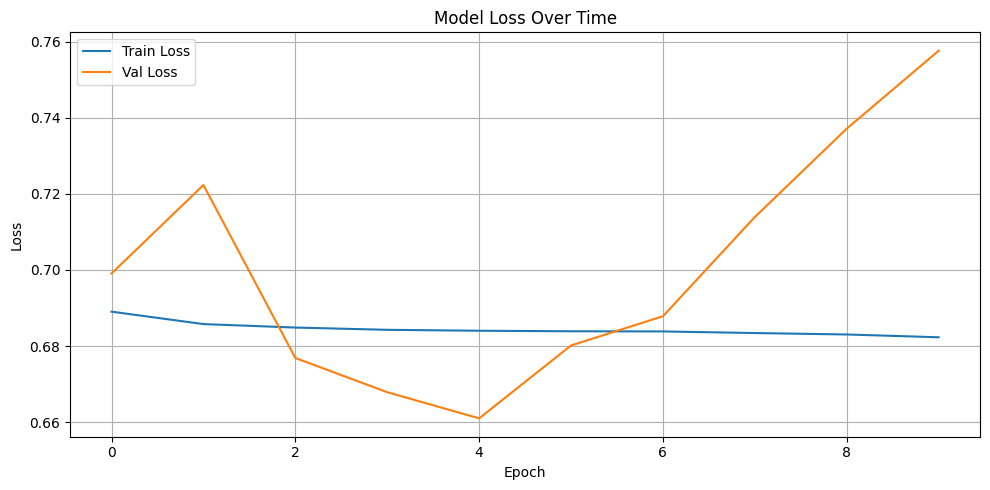

In [7]:

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.utils import class_weight
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

# --- STEP 1: LOAD THE COMBINED DATASET ---
# Navigate to parent directory to find DATA_SET_BUILDER
cwd = os.getcwd()
if cwd.endswith('src'):
    project_root = os.path.dirname(cwd)
else:
    project_root = cwd

# Load the combined dataset
dataset_path = os.path.join(project_root, "DATA_SET_BUILDER", "f1_complete_dataset_2020_2024.csv")

print(f"Loading dataset from: {dataset_path}")
if not os.path.exists(dataset_path):
    print(f"Error: File not found at {dataset_path}")
    print(f"Project root: {project_root}")
    print(f"Contents: {os.listdir(os.path.join(project_root, 'DATA_SET_BUILDER'))}")
    raise FileNotFoundError(f"Dataset not found at {dataset_path}")

full_data = pd.read_csv(dataset_path)
print(f"✓ Loaded dataset: {len(full_data)} rows, {len(full_data.columns)} columns")
print(f"Columns: {full_data.columns.tolist()}")

# --- STEP 2: PREPARE DATA ---
# Use the columns from your dataset
cols_needed = ['driver', 'lap_number', 'lap_time', 'tire_age_laps', 'current_compound', 'track_status', 'pit_this_lap']

# Check if columns exist
missing = [c for c in cols_needed if c not in full_data.columns]
if missing:
    print(f" Warning: Your CSV is missing these columns: {missing}")
    print("Available columns:", full_data.columns.tolist())
    raise ValueError("Please check your dataset column names.")

df = full_data[cols_needed].copy()
df.dropna(inplace=True)
df = df[df['lap_time'] < 200] # Filter safety cars/red flags

# Encode Compounds
le = LabelEncoder()
df['current_compound'] = df['current_compound'].astype(str)
df['compound_encoded'] = le.fit_transform(df['current_compound'])

# Scale Features
scaler = MinMaxScaler()
features = ['lap_time', 'tire_age_laps', 'compound_encoded', 'track_status']
df[features] = scaler.fit_transform(df[features])

print(f"✓ Training Data Ready: {len(df)} laps")

# --- STEP 3: CREATE LSTM SEQUENCES ---
def create_sequences(data, window_size=5):
    X, y = [], []
    # Group by Driver so we don't mix up different cars
    grouped = data.groupby('driver')
    
    for _, group in grouped:
        group = group.sort_values('lap_number')
        vals = group[features].values
        targets = group['pit_this_lap'].values
        
        if len(group) < window_size + 1:
            continue
            
        for i in range(len(vals) - window_size - 1):
            X.append(vals[i : i+window_size])
            y.append(targets[i+window_size+1]) # Predict NEXT lap
            
    return np.array(X), np.array(y)

WINDOW_SIZE = 5
X, y = create_sequences(df, WINDOW_SIZE)
print(f"✓ Created {len(X)} sequences")

# --- STEP 4: TRAIN ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Calculate weights to handle rare pit stops
weights = class_weight.compute_class_weight(
    class_weight='balanced', 
    classes=np.unique(y_train), 
    y=y_train
)
cw = dict(enumerate(weights))

print("\nStarting Training...")
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(
    X_train, y_train, 
    epochs=10, 
    batch_size=64, 
    validation_data=(X_test, y_test),
    class_weight=cw,
    verbose=1
)

# --- STEP 5: RESULTS ---
print("\n--- METRICS ---")
y_pred = (model.predict(X_test) > 0.5).astype(int)
print(classification_report(y_test, y_pred, target_names=['Stay Out', 'Pit In']))

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Loss Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
total=0
found=0
dataset_path = os.path.join(project_root, "DATA_SET_BUILDER", "f1_complete_dataset_2020_2024.csv")
f1dd=pd.read_csv(dataset_path)
print(f1dd.shape)
found=f1dd.shape[0]
dataset_path = os.path.join(project_root, "DATA_SET_BUILDER", "f1_dataset_year_2020.csv")
f1dd=pd.read_csv(dataset_path)
print(f1dd.shape)
total += f1dd.shape[0]
dataset_path = os.path.join(project_root, "DATA_SET_BUILDER", "f1_dataset_year_2021.csv")
f1dd=pd.read_csv(dataset_path)
print(f1dd.shape)
total += f1dd.shape[0]
dataset_path = os.path.join(project_root, "DATA_SET_BUILDER", "f1_dataset_year_2022.csv")
f1dd=pd.read_csv(dataset_path)
print(f1dd.shape)
total += f1dd.shape[0]
dataset_path = os.path.join(project_root, "DATA_SET_BUILDER", "f1_dataset_year_2023.csv")
f1dd=pd.read_csv(dataset_path)
print(f1dd.shape)
total += f1dd.shape[0]
dataset_path = os.path.join(project_root, "DATA_SET_BUILDER", "f1_dataset_year_2024.csv")
f1dd=pd.read_csv(dataset_path)
print(f1dd.shape)
total += f1dd.shape[0]

print(found, total)

(114626, 39)
(17909, 39)
(23303, 39)
(23050, 39)
(23983, 39)
(26381, 39)
114626 114626


**VERSION 2.0**

In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping

# --- STEP 1: LOAD AND CLEAN DATA ---
def duration_to_seconds(td_str):
    """Converts '0 days 00:01:30.500' to 90.5 seconds."""
    if pd.isna(td_str) or td_str == "": return 0
    try:
        # If it's already a number, return it
        if isinstance(td_str, (int, float)): return td_str
        td = pd.to_timedelta(td_str)
        return td.total_seconds()
    except:
        return 0
    
dataset_path = os.path.join(project_root, "DATA_SET_BUILDER", "f1_complete_dataset_2020_2024.csv")
full_data = pd.read_csv(dataset_path)

# Expand feature set to give the model more context
cols_needed = [
    'driver', 'lap_number', 'lap_time', 'tire_age_laps', 'current_compound', 
    'track_status', 'pit_this_lap', 'laps_since_last_pit', 'position', 
    'gap_to_leader', 'is_new_tire'
]

df = full_data[cols_needed].copy()

# Data Cleaning: Convert time strings to seconds
df['lap_time'] = df['lap_time'].apply(duration_to_seconds)
df['gap_to_leader'] = df['gap_to_leader'].apply(duration_to_seconds)

# Filter out extreme outliers (Safety cars/Red flags)
df = df[(df['lap_time'] > 60) & (df['lap_time'] < 150)] 
df.dropna(inplace=True)

# Encode Categorical Data
le = LabelEncoder()
df['compound_encoded'] = le.fit_transform(df['current_compound'].astype(str))

# Feature Scaling
scaler = MinMaxScaler()
features = ['lap_time', 'tire_age_laps', 'compound_encoded', 'track_status', 
            'laps_since_last_pit', 'position', 'gap_to_leader', 'is_new_tire']
df[features] = scaler.fit_transform(df[features])

# --- STEP 2: SEQUENCE CREATION (Predicting the IMMEDIATE next lap) ---
def create_sequences(data, window_size=5):
    X, y = [], []
    grouped = data.groupby('driver')
    
    for _, group in grouped:
        group = group.sort_values('lap_number')
        vals = group[features].values
        targets = group['pit_this_lap'].values
        
        if len(group) < window_size: continue
            
        for i in range(len(vals) - window_size):
            X.append(vals[i : i+window_size])
            # We predict if they pit ON the lap immediately after the window
            y.append(targets[i + window_size]) 
            
    return np.array(X), np.array(y)

WINDOW_SIZE = 5
X, y = create_sequences(df, WINDOW_SIZE)

# --- STEP 3: TRAIN/TEST SPLIT & REFINED WEIGHTS ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,shuffle=False)

# Manual Weights: 1:10 is usually safer than the 1:30 'balanced' default
# This prevents the model from becoming 'trigger happy'
class_weights = {0: 1.0, 1: 8.0} 

# --- STEP 4: ENHANCED LSTM MODEL ---
model = Sequential([
    LSTM(64, activation='tanh', input_shape=(X.shape[1], X.shape[2]), return_sequences=True),
    Dropout(0.2),
    LSTM(32, activation='tanh'),
    BatchNormalization(),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping prevents the model from just memorizing the 'Stay Out' majority
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    X_train, y_train, 
    epochs=20, 
    batch_size=32, 
    validation_data=(X_test, y_test),
    class_weight=class_weights,
    callbacks=[early_stop],
    verbose=1
)

# --- STEP 5: RESULTS ---
y_pred = (model.predict(X_test) > 0.5).astype(int)
print(classification_report(y_test, y_pred, target_names=['Stay Out', 'Pit In']))

Epoch 1/20


/Users/nurulmansibtalukder/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2812/2812 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.9496 - loss: 0.6481 - val_accuracy: 0.9671 - val_loss: 0.2781
Epoch 2/20
2812/2812 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9680 - loss: 0.6184 - val_accuracy: 0.9671 - val_loss: 0.2863
Epoch 3/20
2812/2812 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9675 - loss: 0.6278 - val_accuracy: 0.9671 - val_loss: 0.2794
Epoch 4/20
2812/2812 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9679 - loss: 0.6197 - val_accuracy: 0.9671 - val_loss: 0.2802
703/703 ━━━━━━━━━━━━━━━━━━━━ 1s 582us/step
              precision    recall  f1-score   support

    Stay Out       0.97      1.00      0.98     21755
      Pit In       0.00      0.00      0.00       740

    accuracy                           0.97     22495
   macro avg       0.48      0.50      0.49     22495
weighted avg       0.94      0.97      0.95     22495



/Users/nurulmansibtalukder/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/nurulmansibtalukder/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/nurulmansibtalukder/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

**Version 3.0**

/var/folders/06/1yvcycpd1kq_8p99ct9ft9fr0000gn/T/ipykernel_55430/2796973696.py:79: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  group = group.fillna(0)
/var/folders/06/1yvcycpd1kq_8p99ct9ft9fr0000gn/T/ipykernel_55430/2796973696.py:79: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  group = group.fillna(0)
/var/folders/06/1yvcycpd1kq_8p99ct9ft9fr0000gn/T/ipykernel_55430/2796973696.py:79: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead.

Shape of X: (94250, 10, 19)
Shape of y_pit: (94250,)
Pit stop distribution: [91238  3012]

Training samples: 75400
Test samples: 18850

Model Summary:


/Users/nurulmansibtalukder/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 10, 256)        │       151,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 10, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 10, 128)        │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 32)             │        20,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 340,737 (1.30 MB)

 Trainable params: 340,737 (1.30 MB)

 Non-trainable params: 0 (0.00 B)


Class weights: {0: 1.0, 1: 30.286307053941908}
Epoch 1/100
1885/1885 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.6271 - loss: 1.2588 - precision: 0.0600 - recall: 0.6730 - val_accuracy: 0.6700 - val_loss: 0.5870 - val_precision: 0.0690 - val_recall: 0.7697 - learning_rate: 0.0010
Epoch 2/100
1885/1885 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.6630 - loss: 1.1361 - precision: 0.0664 - recall: 0.7428 - val_accuracy: 0.6658 - val_loss: 0.5568 - val_precision: 0.0682 - val_recall: 0.7697 - learning_rate: 0.0010
Epoch 3/100
1885/1885 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.6644 - loss: 1.0909 - precision: 0.0684 - recall: 0.7667 - val_accuracy: 0.6438 - val_loss: 0.5218 - val_precision: 0.0669 - val_recall: 0.8081 - learning_rate: 0.0010
Epoch 4/100
1885/1885 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.6714 - loss: 1.0756 - precision: 0.0747 - recall: 0.8097 - val_accuracy: 0.6412 - val_loss: 0.5375 - val_precision: 0.0671 - val_recall: 0.8166 - learning_rate: 0.0010


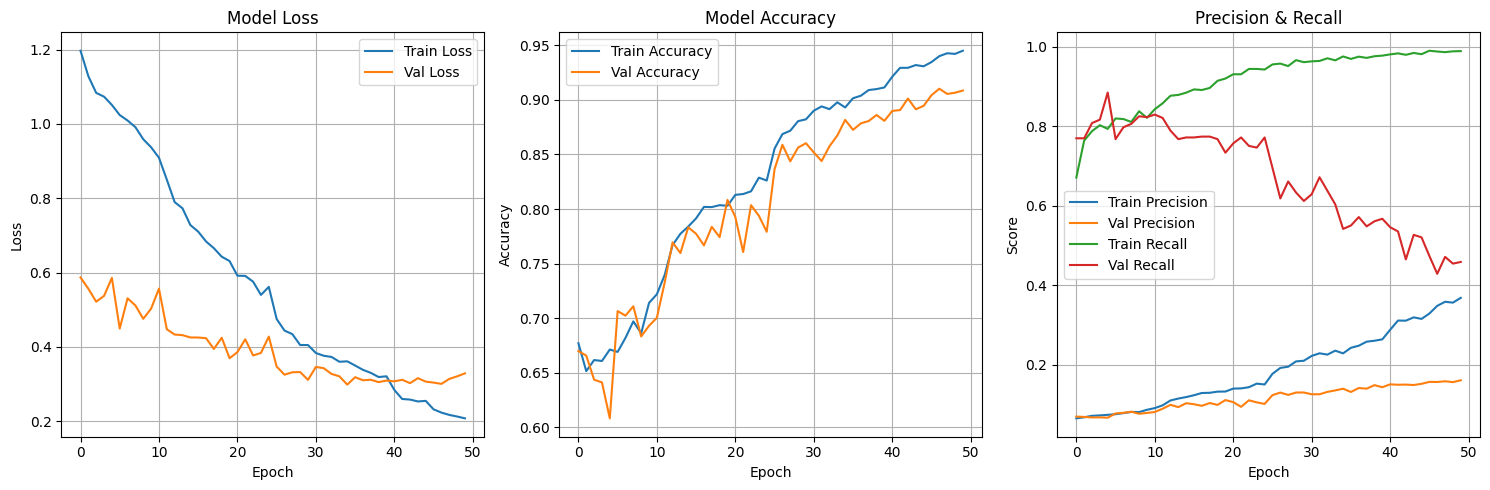

590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


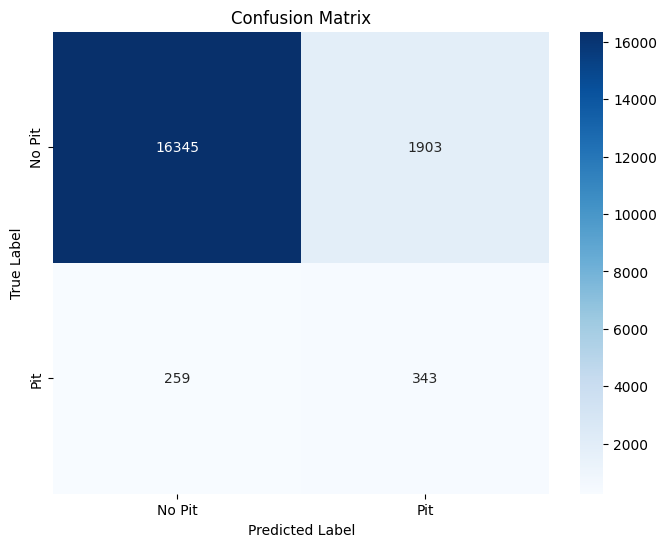


Classification Report
              precision    recall  f1-score   support

      No Pit       0.98      0.90      0.94     18248
         Pit       0.15      0.57      0.24       602

    accuracy                           0.89     18850
   macro avg       0.57      0.73      0.59     18850
weighted avg       0.96      0.89      0.92     18850


Model and preprocessors saved successfully!

Example Usage

# To use the model for prediction:
recent_laps = df[df['driver'] == 'GAS'].tail(10)
pit_prob, should_pit = predict_pit_stop(model, scaler, feature_columns, recent_laps)
print(f"Pit Probability: {pit_prob:.2%}")
print(f"Recommendation: {'PIT' if should_pit else 'STAY OUT'}")



In [16]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

# Load your data
df = pd.read_csv('f1_complete_dataset_2020_2024.csv')

# Feature engineering
def prepare_features(df):
    """
    Prepare features for LSTM model
    """
    # Convert timedelta columns to seconds
    time_columns = ['lap_time', 'lap_time_delta_prev', 'sector1_time', 
                    'sector2_time', 'sector3_time', 'gap_to_leader', 'gap_to_car_ahead']
    
    for col in time_columns:
        if col in df.columns:
            df[col] = pd.to_timedelta(df[col]).dt.total_seconds()
    
    # Encode categorical variables
    le_compound = LabelEncoder()
    le_team = LabelEncoder()
    le_driver = LabelEncoder()
    
    df['current_compound_encoded'] = le_compound.fit_transform(df['current_compound'])
    df['team_encoded'] = le_team.fit_transform(df['team'])
    df['driver_encoded'] = le_driver.fit_transform(df['driver'])
    
    # Select features for the model
    feature_columns = [
        'lap_number',
        'tire_age_laps',
        'tire_life_remaining_est',
        'position',
        'gap_to_leader',
        'gap_to_car_ahead',
        'cars_within_2s_ahead',
        'cars_within_2s_behind',
        'is_being_attacked',
        'is_stuck_in_train',
        'track_temperature',
        'air_temperature',
        'humidity',
        'current_compound_encoded',
        'stint_number',
        'total_pit_stops_so_far',
        'avg_lap_time_on_stint',
        'lap_time',
        'lap_time_delta_prev'
    ]
    
    return df, feature_columns, le_compound

# Prepare sequences for LSTM
def create_sequences(df, feature_columns, sequence_length=10):
    """
    Create sequences for LSTM input
    Each sequence contains the last N laps for a driver
    """
    sequences = []
    targets_pit = []
    targets_compound = []
    
    # Group by driver and race
    grouped = df.groupby(['driver', 'season', 'round_number'])
    
    for name, group in grouped:
        group = group.sort_values('lap_number').reset_index(drop=True)
        
        # Fill NaN values
        group = group.fillna(0)
        
        # Extract features and targets
        features = group[feature_columns].values
        pit_labels = group['pit_this_lap'].values
        
        # Create sequences
        for i in range(len(group) - sequence_length):
            seq = features[i:i + sequence_length]
            target_pit = pit_labels[i + sequence_length]
            
            sequences.append(seq)
            targets_pit.append(target_pit)
            
            # For future tire compound prediction
            if target_pit == 1 and 'next_tire_compound' in group.columns:
                targets_compound.append(group.iloc[i + sequence_length]['next_tire_compound'])
            else:
                targets_compound.append('NONE')
    
    return np.array(sequences), np.array(targets_pit), np.array(targets_compound)

# Prepare data
df, feature_columns, le_compound = prepare_features(df)

# Create sequences
sequence_length = 10  # Use last 10 laps to predict next lap
X, y_pit, y_compound = create_sequences(df, feature_columns, sequence_length)

print(f"Shape of X: {X.shape}")
print(f"Shape of y_pit: {y_pit.shape}")
print(f"Pit stop distribution: {np.bincount(y_pit.astype(int))}")

# Normalize features
scaler = StandardScaler()
X_reshaped = X.reshape(-1, X.shape[-1])
X_scaled = scaler.fit_transform(X_reshaped)
X_scaled = X_scaled.reshape(X.shape)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_pit, test_size=0.2, random_state=42, stratify=y_pit
)

print(f"\nTraining samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")

# Build LSTM Model
def build_lstm_model(input_shape, output_units=1):
    """
    Build LSTM model for pit stop prediction
    """
    model = Sequential([
        Bidirectional(LSTM(128, return_sequences=True), 
                      input_shape=input_shape),
        Dropout(0.3),
        
        Bidirectional(LSTM(64, return_sequences=True)),
        Dropout(0.3),
        
        LSTM(32),
        Dropout(0.2),
        
        Dense(64, activation='relu'),
        Dropout(0.2),
        
        Dense(32, activation='relu'),
        
        # Output layer for binary classification (pit or not)
        Dense(output_units, activation='sigmoid')
    ])
    
    return model

# Create model
model = build_lstm_model(input_shape=(sequence_length, len(feature_columns)))

# Compile model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()]
)

print("\nModel Summary:")
model.summary()

# Callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=0.00001,
        verbose=1
    )
]

# Handle class imbalance
class_weights = {
    0: 1.0,
    1: len(y_train[y_train == 0]) / len(y_train[y_train == 1])
}

print(f"\nClass weights: {class_weights}")

# Train model
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=callbacks,
    class_weight=class_weights,
    verbose=1
)

# Evaluate model
print("\n" + "="*50)
print("Model Evaluation on Test Set")
print("="*50)
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"F1 Score: {2 * (test_precision * test_recall) / (test_precision + test_recall):.4f}")

# Plot training history
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(history.history['precision'], label='Train Precision')
plt.plot(history.history['val_precision'], label='Val Precision')
plt.plot(history.history['recall'], label='Train Recall')
plt.plot(history.history['val_recall'], label='Val Recall')
plt.title('Precision & Recall')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
plt.show()

# Make predictions
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# Confusion Matrix
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Pit', 'Pit'], 
            yticklabels=['No Pit', 'Pit'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "="*50)
print("Classification Report")
print("="*50)
print(classification_report(y_test, y_pred, target_names=['No Pit', 'Pit']))

# Save model and preprocessors
model.save('f1_pit_prediction_model.h5')
import pickle
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
with open('feature_columns.pkl', 'wb') as f:
    pickle.dump(feature_columns, f)

print("\nModel and preprocessors saved successfully!")

# Example prediction function
def predict_pit_stop(model, scaler, feature_columns, recent_laps_df):
    """
    Predict if a pit stop should happen in the next lap
    
    Args:
        model: Trained LSTM model
        scaler: Fitted StandardScaler
        feature_columns: List of feature column names
        recent_laps_df: DataFrame with the last 10 laps of data
    
    Returns:
        pit_probability: Probability of pitting (0-1)
        should_pit: Boolean recommendation
    """
    # Prepare features
    features = recent_laps_df[feature_columns].fillna(0).values
    
    # Scale features
    features_scaled = scaler.transform(features)
    
    # Reshape for LSTM (1 sample, sequence_length, features)
    features_scaled = features_scaled.reshape(1, sequence_length, -1)
    
    # Predict
    pit_probability = model.predict(features_scaled, verbose=0)[0][0]
    should_pit = pit_probability > 0.5
    
    return pit_probability, should_pit

print("\n" + "="*50)
print("Example Usage")
print("="*50)
print("""
# To use the model for prediction:
recent_laps = df[df['driver'] == 'GAS'].tail(10)
pit_prob, should_pit = predict_pit_stop(model, scaler, feature_columns, recent_laps)
print(f"Pit Probability: {pit_prob:.2%}")
print(f"Recommendation: {'PIT' if should_pit else 'STAY OUT'}")
""")